# RT Cooling and Heating

This notebook illustrates how to add cooling and heating by radiation transport (RT) to a prestellar core described by a Bonnor-Ebert sphere. The general idea is that the warm ISM that surrounds the BE-sphere is optically thin to UV-radiation, and can thus be kept at a constant temperature by being exposed to external radiation with that "radiation temperature".  The BE-sphere itself is very optically thick in UV-light, and is hence not affected much by the external UV, except in a thin boundary layer.

At the same time, the whole BE-sphere is optically transparent to infrared radiation.  As a simple estimate, we can use the fact that the Sun has a surface temperature of about 5000 K (in round numbers), and a radiation field that peaks at about 0.5 micrometer ($\mu$m), while the cold ISM, which is about 500 times cooler peaks instead at of the order of 300 $\mu$m.

## Estimates of UV and IR opacitiess

We can estimate the opacity at these very much lower temperatures by using the simple law of _dust extinction_, which states that the absorption by dust is roughly proportional to wavenumber (inverse wavelenght); cf. Fig 1 below.

<img src="./Interstellar_extinction.png" width="600"/>

Fig. 1: The visual extinction as a function of wavenumber (Credit: Karl D. Gordon - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1502191)

Fig. 1 shows that the extinction by dust is essentially linearly proportional to wavenumber, for wavelenghts longer than some 2500 Å.  So, we can conclude that the cold part of the ISM is shielded very efficiently from visual and UV light, while it is at the same time much more transparent to infrared light.

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scaling import scaling, CGS
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 40

#### Relation between extinction and absorption in the visual

Extinction $A_V$ is measured in "magnitudes", with $A_v=1$ corresponging to about $1.8\,10^{21}$ H atoms per cm$^2$. $A_V$ is related to optical depth through the relation from the magnitude law relating intensity (really flux, but it scales the same way)

$$A_V = 2.5 \log_{10}(e)\tau_V $$

since we are counting hydrogen atoms, a good mean molecular weight is about 1.4. We can therefore find $\kappa_V$ in the optical as
$$ \kappa_V\,N_\textrm{col}\,\mu m_p = \int \kappa_V \rho dl = \tau_V = \frac{A_V}{2.5 \log_{10}(e)} = \frac{1}{2.5 \log_{10}(e)} \frac{N_\textrm{col}}{1.8\,10^{21} \textrm{ cm}^{-2}} $$

In [94]:
# notice how we use the scaling module to get unit mass (m_u) in CGS units
mu = 1.4 # molecular mass for atomic hydrogen
kappa_V = 1. / (2.5*np.log10(np.exp(1.))*1.8e21*mu*CGS.m_u)
print('The absorption in the visual is {:.1e} cm2/g.'.format(kappa_V))

The absorption in the visual is 2.2e+02 cm2/g.



#### Absorption at infrared wavelengths
At long wavelengths matter is much more transparent. That is why we use sub-mm and radio telescopes such as ALMA and VLA to observe star forming regions and pierce through dusty galaxies. The visual band has a weighted central wavelength of 540 nm. If there were a completely linear relation between extinction at different wavelengths, then the absorption at e.g.~1 mm would be $\kappa = 220\textrm{ cm}^2 \textrm{ g}^{-1}\,540\textrm{ nm }/\,1\textrm{ mm} = 0.12\textrm{ cm}^2 \textrm{ g}^{-1}$. In reality the relation is not completely linear and a typical value for $\kappa$ at a wavelength of 1 mm is $\kappa_{mm} = 1\textrm{ cm}^2 \textrm{ g}^{-1}$. 

In [95]:
# long wavelength absorption
def kappa_long(T):
    # define absorption at 1 mm
    kappa_mm = 1
    # use Wien's displacement law to find wavelength where thermal radiation peaks
    b = 2.898 # mm K
    peak_mm = b / T
    # assume a inverse proportional relation for kappa
    kappa = kappa_mm * 1. / peak_mm
    return kappa

# general absorption coefficient
def kappa(T,lamb=None):
    b = 0.2898 # cm K    
    if lamb != None:
        TT = b / lamb # assume input wavelength is in cm
    else:
        TT = T
    if TT > 589: # use high temperature coefficient
        lam = b / TT             # corresponding peak wavelength
        kap = 220. * 0.54 / lam  # get kappa
    elif TT > 70.: # between 70 K and 589 K the absorption is relatively flat
        lam = b / 589.
        kap = 220. * 0.54 / lam
    else:          # below 70 K use long wavelength approximation
        kap = kappa_long(TT)
    return kap

### Expected equilibria

If there is an incoming radiation field with a radiation temperature of about 5000 K, the optically thin parts will settle to that temperature, while the optically thick parts will radiate from a surface located at a column density of about $0.005\textrm{ g cm}^{-2}$ in the visual since $\tau = \kappa \,N_\textrm{col}$.

The total surface density at the center of the BE-sphere may be estimated by taking a lenght $L=10^4$ AU, and a mass density of about $\rho = \frac{1 M_O}{L^3}$ giving $\Sigma_\textrm{col} = \rho\,L$. If we assume that the BE-sphere has a temperature of $T=10$ K then we can estimate the optical depth at the peak radiation intensity

In [96]:
sigma_col = (CGS.m_Sun/(1e4*CGS.AU)**3) * (1e4*CGS.AU)
print(sigma_col,"g / cm2")

0.08863620563956215 g / cm2


with a corresponding optical depth of

In [97]:
tau = kappa(T=10.)*sigma_col
print('IR optical depth estimate tau={:.2f}'.format(tau))

IR optical depth estimate tau=0.31


It is thus indeed reasonable to assume that the interior of the BE-sphere is optically thin to IR cooling, which implies an estimated cooling per unit volume and time (factor 4 comes from radiating in all directions instead of through a surface elements, as is done for an optically thick black-body)

\begin{equation}
q_{IR} = - 4\kappa\rho\sigma_{Stefan} T^4 \,,
\end{equation}

and to compensate for that, in such a way that we get the observed temperature of about 10 K, we should add a cosmic ray heating per unit volume that matches it when $T_{BE}=10$ K:

\begin{equation}
q_{CR} = + 4\kappa\rho\sigma_{Stefan} (10 K)^4 \,,
\end{equation}


## Setting up an Bonnor-Ebert sphere

We use the exact BE_sphere procedure from assignment `5a`; cf. the `BE_sphere.ipynb` notebook.  Note that `G` is not a free parameter, but has the value of the actual constant of nature -- scaled to code units !

First we use the HD class (from week 2) to setup a box. Then we use the BE_sphere procedure to fill the grid with reasonable variables

We define a set of units for our experiment by using the scaling package

In [98]:
from BE_sphere import BE_sphere
from HD        import HD

class BE_experiment(HD):
    def __init__(u, units, verbose=0, **kwargs):
        HD.__init__(u,**kwargs)
        u.units = units
        BE_sphere(u, verbose=verbose)
        u.T = u.temperature()

units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, n=100, gamma=1.01);

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430105807743658, 'Stefan': 5477979.176931791, 'h_P': 1.1119233219288195e-82, 'k_B': 2.018220211161387e-57, 'c': 299790.0}
BE_sphere: m_solar, gamma, T_K= 1.0 1.0001 10.0


We can try to plot a few variables to visualize the initial condition

See the Scaling.ipynb notebook for a discussion of the scaling to and from code units !

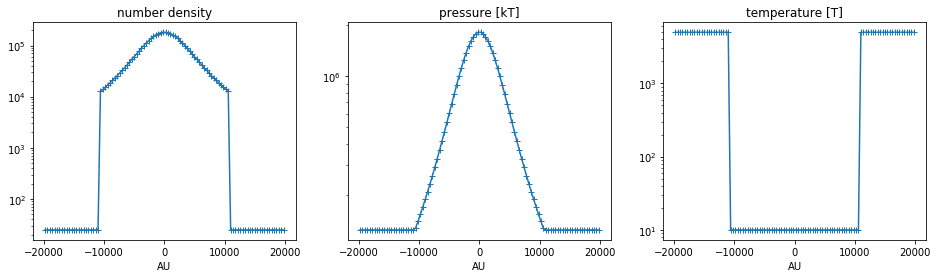

In [99]:
P = u.E*(u.gamma-1.0)*u.units.P
T = u.T*u.units.T
N = u.D*u.units.D/(u.units.mu*CGS.m_u)
P = P/CGS.k_B

plt.figure(figsize=(16,4))
m = u.n[0]//2
x = u.x*u.units.l/CGS.AU
plt.subplot(1,3,1); plt.semilogy(x,N[:,m,m],'-+'); plt.xlabel('AU'); plt.title('number density');        
plt.subplot(1,3,2); plt.semilogy(x,P[:,m,m],'-+'); plt.xlabel('AU'); plt.title('pressure [kT]');
plt.subplot(1,3,3); plt.semilogy(x,T[:,m,m],'-+'); plt.xlabel('AU'); plt.title('temperature [T]');

###  Generic RT solver class

This class contains routines for computing radiative transfer. It defines a basic set of variables describing the setup, a number of service functions, and the integral solver we used Tuesday.

In [100]:
from radiation import Planck

class void(object):
    pass

class RT(object):
    """ basic RT properties """
    def __init__(u, n=32, direction=[0,], waves=[1], 
                 units=CGS, ds=1.):
        u.n       = (n,n,n)
        u.ds      = ds
        u.direction  = np.array(direction)
        u.weight  = 4.*np.pi / len(u.direction) # area per ray 
        u.units   = units
        u.waves   = waves
        u.qtot    = np.zeros(u.n)
    
    def setup (u, D, T, iw=0):
        """ Compute values needed by the solver """
        u.opacity (D, T, iw)
        u.source_function (T, iw)
        u.optical_depths ()
    
    def transpose (u, axis, forward=True):
        """ Transpose values to be used in solver, so axis 
            becomes the new x-axis (when forward is true), 
            or is put back in place (when forward is false)
        """
        if axis==0:
            return
        # Move axis to first index
        if forward:
            if axis==1:
                t = [1,2,0]
            elif axis==2:
                t = [2,0,1]
            # Transpose rho*kappa, source function, and accumulated effective heating
            u.rkap   = np.transpose(u.rkap,t)
            u.source = np.transpose(u.source,t)
            u.qtot   = np.transpose(u.qtot,t)
            # recompute optical depths, since they are a running sum of rkap
            u.optical_depths()
            
        # Move first index to axis
        else:
            if axis==1:
                t = [2,0,1]
            elif axis==2:
                t = [1,2,0]
            # Transpose back rho*kappa, source function, and accumulated effective heating
            u.rkap   = np.transpose(u.rkap,t)
            u.source = np.transpose(u.source,t)
            u.qtot   = np.transpose(u.qtot,t)
            # recompute optical depths, since they are a running sum of rkap
            u.optical_depths()

    def opacity(u, D, T, iw=0):
        """ Absorption for one set of wavelengths """
        wave = u.waves[iw]
        u.rkap = D*kappa(T*u.units.T, lamb=wave) * (u.units.m / u.units.l**2)

    def source_function(u, T, iw=0):
        """ Weighted source funtion for temperatures """
        u.source = Planck(T, u.waves[iw], units=u.units)*u.weight

    def optical_depths (u, ds=u.ds):
        """ optical depth increment across one interval of size u.ds """
        u.dtau = np.zeros(u.n)
        for i in range(u.dtau.shape[0]-1):
            u.dtau[i] = u.optical_depth (u.rkap[i], u.rkap[i+1], ds)

    def optical_depth (u, rk0, rk1, ds=1):
        """ optical depth increment across one interval of size u.ds """
        return 0.5*ds*(rk0 + rk1)
    
    def radiation_solver (u, Ileft=None, Iright=None):
        """ integral solver from the Tuesday exercise """
        dtau = u.dtau
        S = u.source
        I = np.zeros_like(S) # intensity array
        Q = - np.copy(S)     # heating starting at "-S"

        # Forward solution, from the left to the right boundary
        if type(Ileft) != type(None):            
            I[0] = Ileft
        else:
            I[0] = 0.            

        for i in range(1,I.shape[0]):
            e1 = np.exp(-dtau[i-1])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i-1]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i-1] + e4*S[i-1] + e5*S[i]
        
        Q += 0.5*I # add heat from forward ray
        
        # Reverse solution, from the right to the left boundary
        if type(Iright) != type(None):
            I[-1] = Iright
        else:
            I[-1] = 0.

        for i in range(I.shape[0]-2,-1,-1):
            e1 = np.exp(-dtau[i])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i+1] + e4*S[i+1] + e5*S[i]
        
        Q += 0.5*I # add heat from reverse ray
        
        u.qtot += u.rkap*Q
    
    def rt_step(u,u_HD):
    
        u_HD.T = (u_HD.pgas() / u_HD.D)
        
        u.qtot[:] = 0.
        
        for iw in range(len(u.waves)):
            u.setup(u_HD.D, u_HD.T, iw=iw)
            u.radiation_solver()

## Set up Bonnor-Ebert experiment with radiative transfer
The combination of the Bonnor Ebert sphere and the RT class allows us to set up an experiment by
  1. choose the units of the experiment
  2. define our Bonnor-Ebert initial condition
  3. set up the radiative transfer object with a number of wavelengths

In [101]:
units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, n=100, gamma=1.01);

UV = 0.3e-4   # First wavelength bin is at 0.3 micron
IR = 500.0e-4 # Second wavelength bin is at 500. micron

rt = RT(n=u.n[0],waves=[UV,IR],units=u.units,ds=u.ds,direction=[0,1,2])

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430105807743658, 'Stefan': 5477979.176931791, 'h_P': 1.1119233219288195e-82, 'k_B': 2.018220211161387e-57, 'c': 299790.0}
BE_sphere: m_solar, gamma, T_K= 1.0 1.0001 10.0


Having established temperatures and densities we can compute and plot the values used by the RT solver.  

The RT solver primarily needs `rkap` $= \rho\kappa(\rho,T)$ and `source` = $S(T)$, but has a `setup` method that takes `(D, T)` and computes `rkap` and `source` from these.

total UV-tau: 381217.92363277386
total IR-tau: 0.19253430486503725


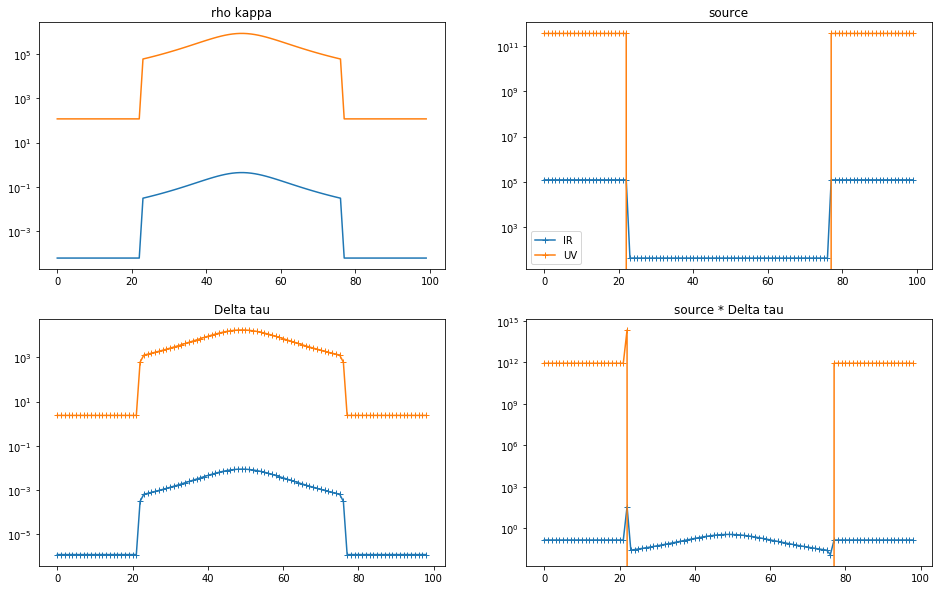

In [102]:
rt.setup(u.D, u.T, iw=0); s0 = rt.source; dtau0 = rt.dtau; rkap0 = rt.rkap
rt.setup(u.D, u.T, iw=1); s1 = rt.source; dtau1 = rt.dtau; rkap1 = rt.rkap
m=u.n[0]//2 # midplane

plt.figure(figsize=(16,10))

plt.subplot(2,2,1); 
plt.semilogy(rkap1[:,m,m]); 
plt.semilogy(rkap0[:,m,m]); 
plt.title('rho kappa');

plt.subplot(2,2,2); 
plt.semilogy(s1[:,m,m],'-+',label='IR'); 
plt.semilogy(s0[:,m,m],'-+',label='UV'); 
plt.title('source'); plt.legend();

plt.subplot(2,2,3); 
plt.semilogy(dtau1[:-1,m,m],'-+'); 
plt.semilogy(dtau0[:-1,m,m],'-+'); 
plt.title('Delta tau');


plt.subplot(2,2,4); 
plt.semilogy((s1*dtau1)[:-1,m,m],'-+'); 
plt.semilogy((s0*dtau0)[:-1,m,m],'-+'); 
plt.title('source * Delta tau');

print('total UV-tau:',np.sum(dtau0[:,m,m]))
print('total IR-tau:',np.sum(dtau1[:,m,m]))

### Images og cooling and heating
We can now compute the cooling and heating in different wave-bands and make slices

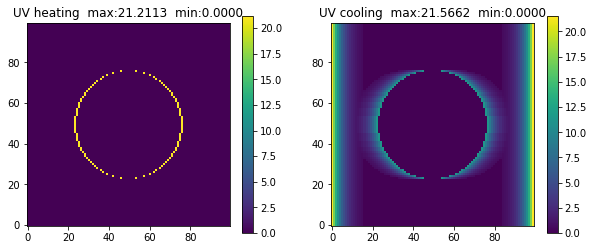

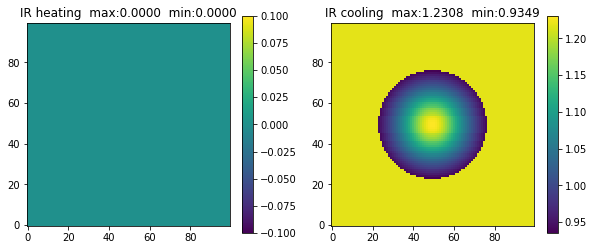

In [103]:
import images as im

m = u.n[2]//2 # use index through center for slices

# UV wavelength:
rt.setup(u.D, u.T, iw=0)
rt.radiation_solver()
heating = +np.maximum(rt.qtot[:,:,m],0.0)
cooling = -np.minimum(rt.qtot[:,:,m],0.0)
im.imshows([heating**0.1,cooling**0.1],title=np.array(['UV heating','UV cooling']));

# IR wavelength:
rt.setup(u.D, u.T, iw=1)
rt.qtot[:] = 0.
rt.radiation_solver()
heating = +np.maximum(rt.qtot[:,:,m],0.0)
cooling = -np.minimum(rt.qtot[:,:,m],0.0)

# We put heating and cooling to the power 0.1 to extend the dynamical range (could also use log)
im.imshows([heating**0.1,cooling**0.1],title=np.array(['IR heating','IR cooling']));

#### __Task 1: Describe Heating and Cooling for the BE sphere__ (10p)

You now have a setup where you can have different wavelengths, and compute the heating and cooling rates for the setup. The solver works by looping over a direction and the a wavelength (either UV or IR).  For each direction it (should) compute the radiation transport in first the forward and then the reverse direction, and add the contributions from the two wavelenghts into `u.qtot`. Describe what is happening in terms of the heating and cooling.

As we see in figure 1, the extinction is much higher in the UV regime, i.e. it is optically thick to UV. Thus, when UV light hits the BE sphere, it is absorbed almost immediately and heats only the outer part of the sphere. Likewise, radiation emitted in the UV by the inner parts of the sphere will almost always be reabsorbed by the sphere, and so it is only the edge the "shines" in UV where we have cooling. It is the only place where UV photons can leave the BE sphere and carry away energy. Here though, the little bit of radiation coming from the outer edges is quite energetic since UV is energetic.

On the other hand, since the sphere is optically thin in IR, it doesn't get heated at all, since photons do not get absorbed. The cooling from the sphere is largest at the center, but O think that is just because of the direction of the rays, i.e. the sun looks like it radiates more in the center but actually it is just due to our sightline. The IR is source dominated since it is in the optically thin limit.

The source term in this case is a blackbody at 10 K within the Bonnert Ebert Sphere and 5000 K in the outside medium. This implies that the peak wavelength from Wiens displacement law will be at approximately 0.3 $\mu$m and 600 nm respectively.  

We see that the edge of the box cools in the UV but this is only due to the open box, and the fact that it only does that to one side is just due to us only integrating over one axis

#### __Task 2: Repair the symmetry of the solutions__ (40p)

Amend the setup so that it respect the symmetry of the solution for a real BE-sphere. In addition, add proper boundary conditions for the two wavelength bands.

The spherical solution is achieved by rotating the axis according to the transpose. The boundary condition is changed from the open boundary to one in which the intensity on the boundary of the box is set by the source.

In [104]:
from radiation import Planck

class void(object):
    pass

class RT(object):
    """ basic RT properties """
    def __init__(u, n=32, direction=[0,], waves=[1], 
                 units=CGS, ds=1.):
        u.n       = (n,n,n)
        u.ds      = ds
        u.direction  = np.array(direction)
        u.weight  = 4.*np.pi / len(u.direction) # area per ray 
        u.units   = units
        u.waves   = waves
        u.qtot    = np.zeros(u.n)
    
    def setup (u, D, T, iw=0):
        """ Compute values needed by the solver """
        u.opacity (D, T, iw)
        u.source_function (T, iw)
        u.optical_depths ()
    
    def transpose (u, axis, forward=True):
        """ Transpose values to be used in solver, so axis 
            becomes the new x-axis (when forward is true), 
            or is put back in place (when forward is false)
        """
        if axis==0:
            return
        # Move axis to first index
        if forward:
            if axis==1:
                t = [1,2,0]
            elif axis==2:
                t = [2,0,1]
            # Transpose rho*kappa, source function, and accumulated effective heating
            u.rkap   = np.transpose(u.rkap,t)
            u.source = np.transpose(u.source,t)
            u.qtot   = np.transpose(u.qtot,t)
            # recompute optical depths, since they are a running sum of rkap
            u.optical_depths()
            
        # Move first index to axis
        else:
            if axis==1:
                t = [2,0,1]
            elif axis==2:
                t = [1,2,0]
            # Transpose back rho*kappa, source function, and accumulated effective heating
            u.rkap   = np.transpose(u.rkap,t)
            u.source = np.transpose(u.source,t)
            u.qtot   = np.transpose(u.qtot,t)
            # recompute optical depths, since they are a running sum of rkap
            u.optical_depths()

    def opacity(u, D, T, iw=0):
        """ Absorption for one set of wavelengths """
        wave = u.waves[iw]
        u.rkap = D*kappa(T*u.units.T, lamb=wave) * (u.units.m / u.units.l**2)

    def source_function(u, T, iw=0):
        """ Weighted source funtion for temperatures """
        u.source = Planck(T, u.waves[iw], units=u.units)*u.weight

    def optical_depths (u, ds=u.ds):
        """ optical depth increment across one interval of size u.ds """
        u.dtau = np.zeros(u.n)
        for i in range(u.dtau.shape[0]-1):
            u.dtau[i] = u.optical_depth (u.rkap[i], u.rkap[i+1], ds)

    def optical_depth (u, rk0, rk1, ds=1):
        """ optical depth increment across one interval of size u.ds """
        return 0.5*ds*(rk0 + rk1)
    
    def radiation_solver (u, Ileft=None, Iright=None):
        """ integral solver from the Tuesday exercise """

        # Forward solution, from the left to the right boundary
        for axis in [0,1,2]:
            dtau = u.dtau
            S = u.source
            I = np.zeros_like(S) # intensity array
            Q = - np.copy(S)     # heating starting at "-S", assuming I=0 initilly
            if axis != 0:
                Q = np.zeros_like(S)
            u.transpose(axis, forward=True) 
        
            # Reverse solution, from the right to the left boundary
            if type(Iright) != type(None):
                I[-1] = Iright
            else:
                I[-1] = u.source[-1] 
                
            for i in range(I.shape[0]-2,-1,-1):
                e1 = np.exp(-dtau[i])
                e2 = 1.0 - e1
                e3 = e1 - e2/dtau[i] 
                e4 = - e3
                e5 = e2 + e3
                I[i] = e1*I[i+1] + e4*S[i+1] + e5*S[i]
            I[-1] = e1*I[0] + e4*S[0] + e5*S[-1]

            Q += 1/6*I # add heat from reverse ray

            if type(Ileft) != type(None):            
                I[0] = Ileft
            else:
                I[0] = u.source[0] #+= u.source[0]/6  #u.source[0]=0        

            for i in range(1,I.shape[0]):
                e1 = np.exp(-dtau[i-1])
                e2 = 1.0 - e1
                e3 = e1 - e2/dtau[i-1]
                e4 = - e3
                e5 = e2 + e3
                I[i] = e1*I[i-1] + e4*S[i-1] + e5*S[i]
            I[0] = e1*I[-1] + e4*S[-1] + e5*S[0]
            
            Q += 1/6*I # add heat from forward ray            
            u.qtot += u.rkap*Q

            u.transpose(axis, forward=False) 
    
    def rt_step(u,u_HD):
    
        u_HD.T = (u_HD.pgas() / u_HD.D)
        
        u.qtot[:] = 0.
        
        for iw in range(len(u.waves)):
            u.setup(u_HD.D, u_HD.T, iw=iw)
            u.radiation_solver( )

In [105]:
units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, n=100, gamma=1.01);

UV = 0.3e-4   # First wavelength bin is at 0.3 micron
IR = 500.0e-4 # Second wavelength bin is at 500. micron

rt = RT(n=u.n[0],waves=[UV,IR],units=u.units,ds=u.ds,direction=[0,1,2])

rt.setup(u.D, u.T, iw=0); s0 = rt.source; dtau0 = rt.dtau; rkap0 = rt.rkap
rt.setup(u.D, u.T, iw=1); s1 = rt.source; dtau1 = rt.dtau; rkap1 = rt.rkap

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430105807743658, 'Stefan': 5477979.176931791, 'h_P': 1.1119233219288195e-82, 'k_B': 2.018220211161387e-57, 'c': 299790.0}
BE_sphere: m_solar, gamma, T_K= 1.0 1.0001 10.0


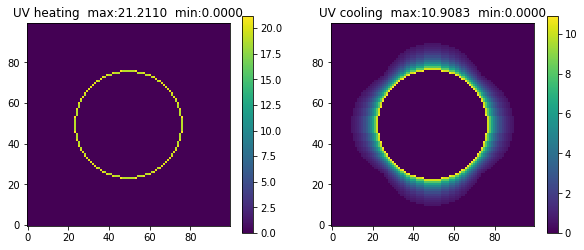

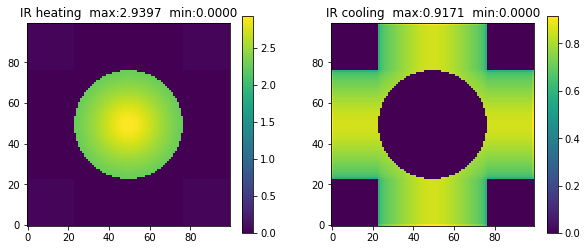

In [106]:
import images as im

m = u.n[2]//2 # use index through center for slices
# UV wavelength:
rt.setup(u.D, u.T, iw=0)
rt.radiation_solver()
heating = +np.maximum(rt.qtot[:,:,m],0.0)
cooling = -np.minimum(rt.qtot[:,:,m],0.0)
im.imshows([heating**0.1,cooling**0.1],title=np.array(['UV heating','UV cooling']));

# IR wavelength:
rt.setup(u.D, u.T, iw=1)
rt.qtot[:] = 0.
rt.radiation_solver(Ileft=I0, Iright=I0)
heating = +np.maximum(rt.qtot[:,:,m],0.0)
cooling = -np.minimum(rt.qtot[:,:,m],0.0)

# We put heating and cooling to the power 0.1 to extend the dynamical range (could also use log)
im.imshows([heating**0.1,cooling**0.1],title=np.array(['IR heating','IR cooling']));

As we have discussed in class, setting the intensity equal to the source on the boundary removes the edge cooling in the UV. However, in the IR we create an artificial cross of all regions that are causually connected. Note that this rigidity only happens because we roll only along one axis at a time! This however is of course unphysical. I think the mistake that we are making is that we assume that the optically thin actually adds all the instensity back.

We can see that the cross is a general effect that also occurs in the UV it is just harder to se

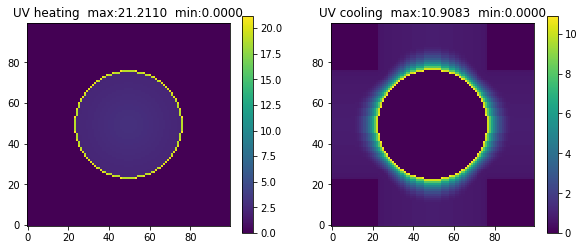

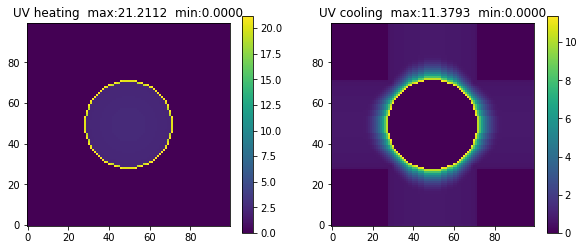

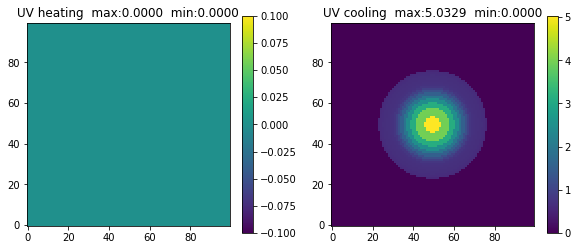

In [107]:
import images as im

m = u.n[2]//2 # use index through center for slices

# UV wavelength:
rt.setup(u.D, u.T, iw=0) 
rt.radiation_solver()
heating = +np.maximum(rt.qtot[:,:,m],0.0)
cooling = -np.minimum(rt.qtot[:,:,m],0.0)
im.imshows([heating**0.1,cooling**0.1],title=np.array(['UV heating','UV cooling']));

m=m+15
heating = +np.maximum(rt.qtot[:,:,m],0.0)
cooling = -np.minimum(rt.qtot[:,:,m],0.0)
im.imshows([heating**0.1,cooling**0.1],title=np.array(['UV heating','UV cooling']));

m=m+15
heating = +np.maximum(rt.qtot[:,:,m],0.0)
cooling = -np.minimum(rt.qtot[:,:,m],0.0)
im.imshows([heating**0.1,cooling**0.1],title=np.array(['UV heating','UV cooling']));


We can also check that everything looks okay as we slice our way through the BE sphere.

## HD with self gravity and radiation
Notice that I had to add a fudge factor, since there is a non-trivial conversion between radition from rays, and the angle integrated net heating rate.
To reduce clutter I have moved all the hydro and selfgravity files out of the notebook and in to seperate routines. They are essential the same as in last week. The main addition here is that first the HD + self-gravity solver is called and then the RT related source terms are added.

In [108]:
## from HD          import HD
from solvers     import MUSCL
from Riemann     import HLL
from selfgravity import FFT
from scaling     import scaling, CGS
    
# Add a fudge factor, since we are not taking in to account
# directional coverage and wavelength integration for heating and cooling
fudge_factor = 1e-12
super_fudge = 14
# Function that combines af HD solver with radiative transfer
def Step(u, rt, tend=None):
    
    # Add half a time step worth of heating / cooling from last timestep
    u.E += 0.5*u.dt*rt.qtot * fudge_factor
    u.E  += 0.5*u.D *u.dt * super_fudge
    dtold = u.dt

    # Take a HD step
    u.solver.Step(u,tend=tend)
    
    # Add another half a time step worth of heating / cooling from last timestep
    u.E += (u.dt - 0.5*dtold)*rt.qtot * fudge_factor
    u.E += (u.dt - 0.5*dtold)*u.D*super_fudge
    dold = np.copy(u.D)
    qold = np.copy(rt.qtot)

    # Refresh the net heating / cooling rate
    rt.rt_step(u)
    
    # Correct half a time step worth of heating / cooling with new solution
    u.E += 0.5*u.dt*(rt.qtot - qold)  * fudge_factor
    u.E += 0.5*u.dt*(u.D - dold)*super_fudge

In [109]:
units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, n=100, gamma=1.01);

UV = 0.3e-4   # First wavelength bin is at 0.3 micron
IR = 500.0e-4 # Second wavelength bin is at 500. micron

rt = RT(n=u.n[0],waves=[UV,IR],units=u.units,ds=u.ds)
u.solver = MUSCL(u)

# Initial net heating / cooling rate
rt.rt_step(u)

Step(u, rt)

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430105807743658, 'Stefan': 5477979.176931791, 'h_P': 1.1119233219288195e-82, 'k_B': 2.018220211161387e-57, 'c': 299790.0}
BE_sphere: m_solar, gamma, T_K= 1.0 1.0001 10.0


Example of how to take 20 timesteps and plot the evolution (if executed several times, it will continue the evolution)

In [ ]:
import images as im
T_array = []

for i in range(100):
    Step(u, rt)
    print("It, time [yr, code_units]: ", u.it, u.t * u.units.t / CGS.yr, u.t)
    u.T = (u.pgas() / u.D) * u.units.T
    m = u.n[2]//2
    dens = u.D[:,:,m]*u.units.D / (CGS.mu*CGS.m_u)
    vx = (u.velocity())[0,:,:,m]*u.units.v/CGS.kms
    temp = u.T[:,:,m]
    T_array.append(u.T[:,50,50])
    if i%10==0:
        im.imshows([dens,temp,vx,fudge_factor*rt.qtot[:,:,m]],title=np.array(['Density','Temperature','vx','Q']));

It, time [yr, code_units]:  2 182.2215969114916 0.0019195305736070343
It, time [yr, code_units]:  3 273.33177788711157 0.002879289355846876
It, time [yr, code_units]:  4 364.44161067735575 0.0038390444702861644
It, time [yr, code_units]:  5 455.55109839836615 0.0047987959497504794
It, time [yr, code_units]:  6 546.6602441812902 0.005758543827223471
It, time [yr, code_units]:  7 637.7690511435493 0.006718288135544198
It, time [yr, code_units]:  8 728.8775224195438 0.007678028907730575
It, time [yr, code_units]:  9 819.9856280514783 0.008637765828205827
It, time [yr, code_units]:  10 911.0925428318435 0.009597490204196589
It, time [yr, code_units]:  11 1002.196986283817 0.01055718854710189
It, time [yr, code_units]:  12 1093.298227310643 0.011516853155515316
It, time [yr, code_units]:  13 1184.396744886471 0.012476489074972306
It, time [yr, code_units]:  14 1275.4911938410594 0.013436082135388463
It, time [yr, code_units]:  15 1366.5824831469015 0.0143956419119213
It, time [yr, code_unit

In [ ]:
plt.figure(figsize=(12,6)) 
for i in np.arange(0, np.shape(T_array)[0],5):
    plt.plot(u.coords[0,:,50,50], T_array[i], color=[i/np.shape(T_array)[0], 0, 0], alpha=0.4, label=str(i))
plt.title('Temperature at different steps')
plt.xlabel(f'X [{u.units.l} cm]'), plt.ylabel('Temperature')
plt.legend()

As we see, the center of the sphere stays the same temperature, and in general the outside too, but the edge slowly heats. Most curiously, when getting above 60-70 iterations, we seem to introduce some kind of "cold" wave, so we can see the we certainly did not remove all edge cooling.

### Radial plots
Define ```rr``` as the radial distance from the center (see ```HD.py```) and make plots of radial velocity, pressure, temperature, and density

In [ ]:
rr = np.sqrt(np.sum(u.coords**2,axis=0))
vr = np.sum(u.velocity()*u.coords,axis=0) / rr

plt.figure(figsize=(16,10))
plt.subplot(3,2,1); plt.scatter(rr, vr, linewidths=0.02)
plt.xlabel('AU'); plt.title('radial velocity');        

plt.subplot(3,2,2); plt.scatter(rr, u.pgas(), linewidths=0.02)
plt.xlabel('AU'); plt.title('pressure [kT]');

plt.subplot(3,2,3); plt.scatter(rr, u.T,linewidths=0.02)
plt.xlabel('AU'); plt.title('temperature [T]');

plt.subplot(3,2,4); plt.scatter(rr, u.D,linewidths=0.02)
plt.xlabel('AU'); plt.title('density');

plt.subplot(3,2,5); plt.scatter(rr, fudge_factor*rt.qtot,linewidths=0.02)
plt.xlabel('AU'); plt.title('Total net heating');

To leave a comment on the above plots.

Adding cosmic rays should raise the temperature everywhere since the sphere is not optically thick in the infrared. Therefore, depending on the fudge parameter related to CR we may heat the entire box. However, as ALbert and I found, the CR fudge factor cannot be very high, because then our solver becomes numerically unstable, so we don't have much wiggle room which made us unsure. Note though that that isn't strictly a requirement as our boundary condition enforces that the edge neither cools nor heats. 

In the plot showing temperature distribution over time, we see that the evolution in temperature happens at the bounds of the Bonnert Ebert Sphere as the two temperatures slowly equilibrate, but this of course happens slowly and only at the very boundary.

#### __Task 3: Setup a full experiment and discuss the results; include cosmic rays__ (40p)

Once the radiative transfer is working, you can take the next step and couple it to Hydro dynamics. You should be able to see things changing in three different ways as the experiment evolves.  Run it for at least a few minutes, but for as long as you like -- or as long as it works:

1. The very sharp discontinuity is changing.
   
The discontinuity between the Bonnert Ebert sphere and the surroundings in temperature equilibrates slowly as can be seen above. The hot exterior regions will cool a little as the cool sphere slowly heat inwards.
   
2. The region outside the discontinuity should basically keep its high temperature. Is this the case, and if not, how little or how much is the temperature changing there?
   
Since we added some new boundary conditions the temperature of the medium remains the same. See above for how the temperature outside the optically thick BE-sphere changes with time-

              
3. The temperature at the center should stay at 10 K, but it can only do that if the cooling in the IR is compensated for by a corresponding heating, which in reality comes mainly from cosmic rays. Add an artificial terms, as in the notes above, so the temperature is stabilized.
            
The cosmic rays are mainly optically thin heating agents since they originate as low-T Blackbody agents. Therefore we determined that they must heat proportionally to the mass in a grid cell. As seen we cannot exactly cancel the cooling, but we do implement a cosmic ray term, which is proportional to the density in each cell with a very arbitrary fudge factor. I am especially iffy about this because our solution is numerically unstable for high super_fudge. We treat the cosmic rays similar to the radiative terms and use operator splitting as this seemed to be the right approach. Again, the temperature is stable around most of the sphere, except on the boundary, but that does still make sense. We have at least stopped the infrared cooling from the core.

#### __Absalon turn-in:__

Please answer the tasks here, at the end, and submit by uploading the notebook and corresponding PDF.

#### __Task 1: Describe Heating and Cooling for the BE sphere__ (10p)

You now have a setup where you can have different wavelengths, and compute the heating and cooling rates for the setup. The solver works by looping over a direction and the a wavelength (either UV or IR).  For each direction it (should) compute the radiation transport in first the forward and then the reverse direction, and add the contributions from the two wavelenghts into `u.qtot`. Describe what is happening in terms of the heating and cooling.

As we see in figure 1, the extinction is much higher in the UV regime, i.e. it is optically thick to UV. Thus, when UV light hits the BE sphere, it is absorbed almost immediately and heats only the outer part of the sphere. Likewise, radiation emitted in the UV by the inner parts of the sphere will almost always be reabsorbed by the sphere, and so it is only the edge the "shines" in UV where we have cooling. It is the only place where UV photons can leave the BE sphere and carry away energy. Here though, the little bit of radiation coming from the outer edges is quite energetic since UV is energetic.

On the other hand, since the sphere is optically thin in IR, it doesn't get heated at all, since photons do not get absorbed. The cooling from the sphere is largest at the center, but O think that is just because of the direction of the rays, i.e. the sun looks like it radiates more in the center but actually it is just due to our sightline. The IR is source dominated since it is in the optically thin limit.

The source term in this case is a blackbody at 10 K within the Bonnert Ebert Sphere and 5000 K in the outside medium. This implies that the peak wavelength from Wiens displacement law will be at approximately 0.3 $\mu$m and 600 nm respectively.  

We see that the edge of the box cools in the UV but this is only due to the open box, and the fact that it only does that to one side is just due to us only integrating over one axis

### Task 2

The spherical solution is achieved by rotating the axis according to the transpose. The boundary condition is changed from the open boundary to one in which the intensity on the boundary of the box is set by the source.

As we have discussed in class, setting the intensity equal to the source on the boundary removes the edge cooling in the UV. However, in the IR we create an artificial cross of all regions that are causually connected. Note that this rigidity only happens because we roll only along one axis at a time! This however is of course unphysical. I think the mistake that we are making is that we assume that the optically thin actually adds all the instensity back.

One extra thing that I could have done would be to check that the BE sphere is actually isotropic but that seemed a given as we had engineered it that way.

#### __Task 3: Setup a full experiment and discuss the results; include cosmic rays__ (40p)

Once the radiative transfer is working, you can take the next step and couple it to Hydro dynamics. You should be able to see things changing in three different ways as the experiment evolves.  Run it for at least a few minutes, but for as long as you like -- or as long as it works:

1. The very sharp discontinuity is changing.
   
The discontinuity between the Bonnert Ebert sphere and the surroundings in temperature equilibrates slowly as can be seen above. The hot exterior regions will cool a little as the cool sphere slowly heat inwards.
   
2. The region outside the discontinuity should basically keep its high temperature. Is this the case, and if not, how little or how much is the temperature changing there?
   
Since we added some new boundary conditions the temperature of the medium remains the same. See above for how the temperature outside the optically thick BE-sphere changes with time-

              
3. The temperature at the center should stay at 10 K, but it can only do that if the cooling in the IR is compensated for by a corresponding heating, which in reality comes mainly from cosmic rays. Add an artificial terms, as in the notes above, so the temperature is stabilized.
            
The cosmic rays are mainly optically thin heating agents since they originate as low-T Blackbody agents. Therefore we determined that they must heat proportionally to the mass in a grid cell. As seen we cannot exactly cancel the cooling, but we do implement a cosmic ray term, which is proportional to the density in each cell with a very arbitrary fudge factor. I am especially iffy about this because our solution is numerically unstable for high super_fudge. We treat the cosmic rays similar to the radiative terms and use operator splitting as this seemed to be the right approach. Again, the temperature is stable around most of the sphere, except on the boundary, but that does still make sense. We have at least stopped the infrared cooling from the core.